In [1]:
import pandas as pd
import numpy as np

In [2]:
train=pd.read_csv("training_variants")
print(train.shape)
train.head(2)
Y_train=train["Class"]
train=train.drop("Class",axis=1)

(3321, 4)


In [3]:
data_text =pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', data_text.shape[0])
print('Number of features : ', data_text.shape[1])
print('Features : ', data_text.columns.values)
data_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [4]:
train.head(1)

,ID,Gene,Variation
0,0,FAM58A,Truncating Mutations


In [5]:
test=pd.read_csv("test_variants")
print(test.shape)
test.head(2)

(5668, 3)


,ID,Gene,Variation
0,0,ACSL4,R570S
1,1,NAGLU,P521L


In [6]:
test_data_text =pd.read_csv("test_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
print('Number of data points : ', test_data_text.shape[0])
print('Number of features : ', test_data_text.shape[1])
print('Features : ', test_data_text.columns.values)
test_data_text.head()

Number of data points :  5668
Number of features :  2
Features :  ['ID' 'TEXT']


,ID,TEXT
0,0,2. This mutation resulted in a myeloproliferat...
1,1,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,Vascular endothelial growth factor receptor (V...
3,3,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,Abstract Retinoblastoma is a pediatric retina...


# Working on text data

In [7]:
import re
from tqdm import tqdm

In [8]:
# removing html tag 
clean_text=[]
for i in tqdm(data_text["TEXT"]):
    i=str(i)
    k=re.sub('<.*?>'," ",i)
    z=re.sub("[?|!|\'|'|#]"," ",k)
    l=re.sub('\s+',' ',z)
    clean_text.append(l)

100%|█████████████████████████████████████████████████████████████████████████████| 3321/3321 [00:18<00:00, 182.67it/s]


In [9]:
from nltk.corpus import stopwords
Stop=set(stopwords.words("english"))

In [10]:
sent=[]
for i in tqdm(clean_text):
    st=" "
    for word in i.split():
        l=word.lower()
        if l not in Stop:
            st=st+" "+l
    sent.append(st)

100%|██████████████████████████████████████████████████████████████████████████████| 3321/3321 [02:47<00:00, 19.84it/s]


In [11]:
train["TEXT"]=sent

# Test-Text Data

In [12]:
test_clean_text=[]
for i in tqdm(test_data_text["TEXT"]):
    i=str(i)
    k=re.sub('<.*?>'," ",i)
    z=re.sub("[?|!|\'|'|#]"," ",k)
    l=re.sub('\s+',' ',z)
    test_clean_text.append(l)

100%|█████████████████████████████████████████████████████████████████████████████| 5668/5668 [00:24<00:00, 231.80it/s]


In [13]:
test_sent=[]
for i in tqdm(test_clean_text):
    st=" "
    for word in i.split():
        l=word.lower()
        if l not in Stop:
            st=st+" "+l
    test_sent.append(st)

100%|██████████████████████████████████████████████████████████████████████████████| 5668/5668 [07:59<00:00, 11.81it/s]


In [14]:
#TF-IDF W2V
from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
print(train_sentence.shape)
print(test_sentence.shape)

(3321, 5000)
(5668, 5000)


In [17]:
from sklearn.model_selection import train_test_split

In [18]:
x_train,x_test,y_train,y_test=train_test_split(train,Y_train,test_size=0.30,stratify=Y_train)

In [19]:
print("traindata shape",x_train.shape)
print("testdata shape",x_test.shape)
print("Ytraindata shape",y_train.shape)
print("Ytestdata shape",y_test.shape)


traindata shape (2324, 4)
testdata shape (997, 4)
Ytraindata shape (2324,)
Ytestdata shape (997,)


In [20]:
tf_idf=TfidfVectorizer(min_df=3,ngram_range=[1,4],max_features=5000)
tf_idf.fit(x_train["TEXT"].values)
train_text=tf_idf.transform(x_train["TEXT"].values)
test_text=tf_idf.transform(x_test["TEXT"].values)

In [22]:
print(train_text.shape)

(2324, 5000)


In [23]:
#Gene
from sklearn.feature_extraction.text import CountVectorizer

In [24]:
ct=CountVectorizer(min_df=3)
ct.fit(x_train["Gene"])
train_gene=ct.transform(x_train["Gene"].values)
test_gene=ct.transform(x_test["Gene"].values)

In [25]:
print(train_gene.shape)

(2324, 140)


In [26]:
#Variation
ck=CountVectorizer(min_df=3)
ck.fit(x_train["Variation"])
train_Variation=ck.transform(x_train["Variation"].values)
test_Variation=ck.transform(x_test["Variation"].values)

In [27]:
print(train_Variation.shape)

(2324, 31)


In [28]:
from scipy.sparse import hstack
training=hstack((train_gene,train_Variation,train_text))
test=hstack((test_gene,test_Variation,test_text))

In [29]:
print(training.shape)
print(test.shape)

(2324, 5171)
(997, 5171)


# Machine Learning Model

In [34]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score,log_loss,confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [31]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error=[]
for i in tqdm(alpha):
    clf=MultinomialNB(alpha=i)
    clf.fit(training,y_train)
    sig_clf=CalibratedClassifierCV(clf,method="sigmoid")
    sig_clf.fit(training,y_train)
    sig_proba=sig_clf.predict_proba(test)
    cv_log_error.append(log_loss(y_test,sig_proba,labels=clf.classes_,eps=1e-15))
    


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:07<00:00,  1.10it/s]


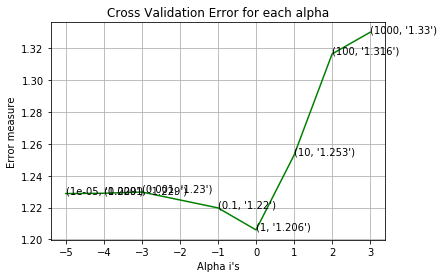

In [35]:
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error,c='g')
for i, txt in enumerate(np.round(cv_log_error,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error[i]))
plt.grid()
#plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [36]:
import seaborn as sns

In [37]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T) 
    
    B =(C/C.sum(axis=0))

    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

-------------------- Confusion matrix --------------------


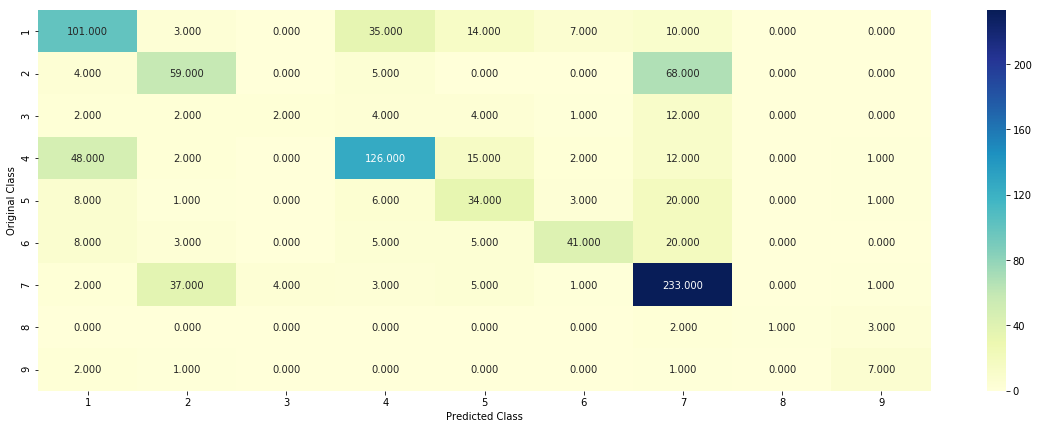

-------------------- Precision matrix (Columm Sum=1) --------------------


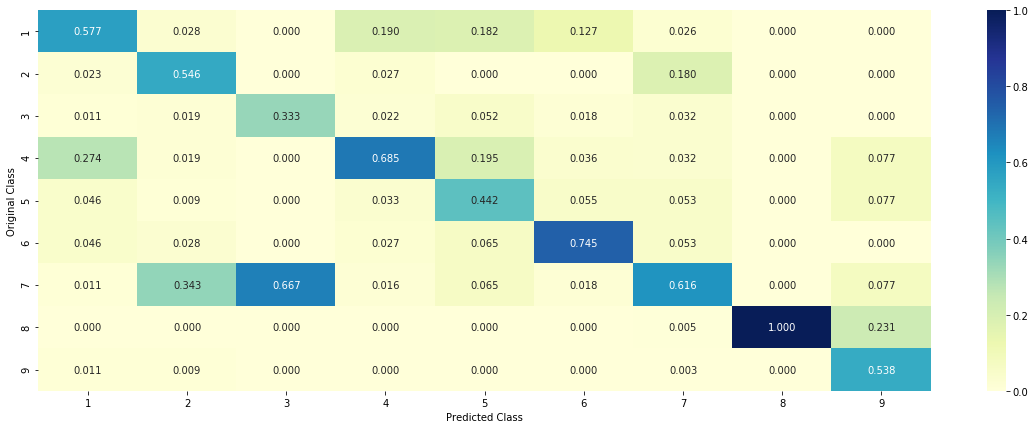

-------------------- Recall matrix (Row sum=1) --------------------


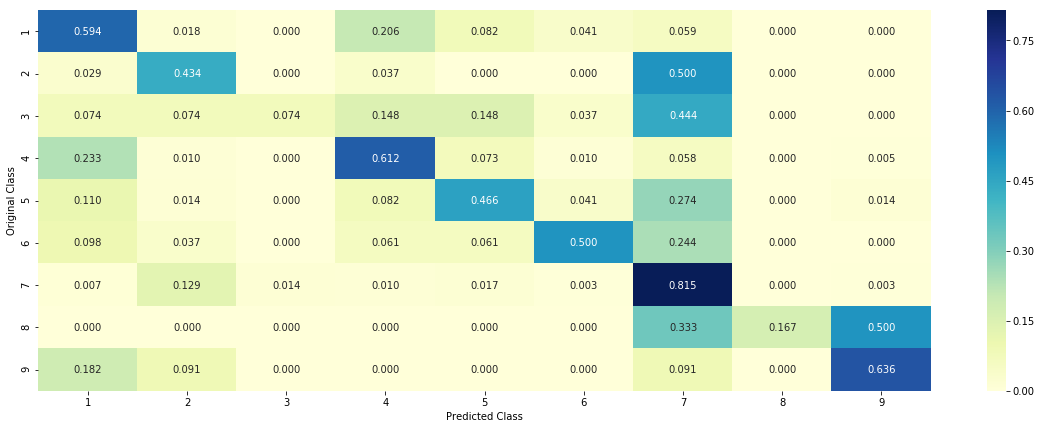

In [38]:
clf=MultinomialNB(alpha=0.1)
clf.fit(training,y_train)
sig_clf=CalibratedClassifierCV(clf,method="sigmoid")
sig_clf.fit(training,y_train)
sig_proba=sig_clf.predict_proba(test)
plot_confusion_matrix(y_test, sig_clf.predict(test.toarray()))  

In [40]:
test_point_index = 100
no_feature = 100
#test=test.todense()
#y_test=y_test.todense()
predicted_cls = sig_clf.predict(test[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test[test_point_index]),4))
print("Actuall Class :", y_test.iloc[100])
print("-"*50)


Predicted Class : 7
Predicted Class Probabilities: [[0.0665 0.1664 0.0214 0.0749 0.0434 0.0411 0.5778 0.0049 0.0036]]
Actuall Class : 7
--------------------------------------------------
